---
title: Telecommunication towers component clasification. Part 2. PyTorch  
author: "Francisco Mussari"  
date: 2023-03-06  
image: "fastai API levels.PNG"  
categories: [deeplearning, dataloaders, API, transforms, Walk with fastai, PyTorch, fastai]  
format:
  html:
    toc: true
    toc-depth: 3
    
---

## Introduction
[Zach Mueller](https://twitter.com/TheZachMueller) proposed us to create a Gradio app as a homework for for the course [Walk with fastai, the missing pieces for success](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html).

I had already deployed a [Tower Classificacion App](https://huggingface.co/spaces/fmussari/tower_parts_cassifier) as a homework for [Practical Deep Learning for Coders](https://course.fast.ai/).  

Here the link to **Part 1** post: 
[Part 1. Tower Parts Classisfier with fastai](./Part_1__Tower_Parts_Classisfier_with_fastai.ipynb)  

The new thing here is that everythong but the training is going to be done using pure PyTorch, which was teched in Zach's course.

## Import Libraries

In [ ]:
from pathlib import Path
from miniai.datasets import show_images

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch
import torchvision.transforms as tvtfms

from PIL import Image

import pandas as pd
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt

## Image Data

There are 478 images in 8 relatively "easy" to distinguish categories (components). 

- Base plate
- Grounding bar
- Identification
- Ladder
- Light
- Lightning rod
- Platform
- Transmission lines

You can download the pictures [here](https://drive.google.com/open?id=1Prtb9VbTau8Zk4c4K0YGFfL98MsGuf-F).
 
There are two folders, one for the training (train) and the other for validation set (valid).

In [ ]:
path = Path("photos")
[folder.stem for folder in path.iterdir()]

['train', 'valid']

In [ ]:
train_path = path / "train"
valid_path = path / "valid"

And in each folder there is one folder for each label.

In [ ]:
labels = [folder.stem for folder in train_path.iterdir()]
number_of_labels = len(labels)
print(labels)

['base_plate', 'grounding_bar', 'identification', 'ladder', 'light', 'lightning_rod', 'platform', 'transmission_lines']


In [ ]:
int_to_label = {k:v for k,v in enumerate(labels)}
label_to_int = {k:v for v,k in int_to_label.items()}
print(label_to_int)

{'base_plate': 0, 'grounding_bar': 1, 'identification': 2, 'ladder': 3, 'light': 4, 'lightning_rod': 5, 'platform': 6, 'transmission_lines': 7}


### Visualizing the distribution o labels

In [ ]:
labels = [label.parts[-1] for label in train_path.iterdir()]
train_quantity = [len(list(each.iterdir())) for each in train_path.iterdir()]
valid_quantity = [len(list(each.iterdir())) for each in valid_path.iterdir()]
df = pd.DataFrame()

df['label'] = labels * 2
df['set'] = ['train'] * 8 + ['valid'] * 8
df['number of pics'] = train_quantity + valid_quantity

In [ ]:
fig = px.bar(
    df, x="set", y="number of pics",
    color='label', barmode='group',
    height=400
)
fig.show()

## Creating PyTorch Dataset

### Dataset Class

This class is based in the amazing [Walk with fastai course](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html) whose [Using Raw PyTorch]() lesson has the following note in the Dataset code.

> This example is highly based on the work of Sylvain Gugger
for the Accelerate notebook example which can be found here: 
https://github.com/huggingface/notebooks/blob/main/examples/accelerate_examples/simple_cv_example.ipynb

In [ ]:
class TowerPartsDataset(Dataset):
    def __init__(self, path:Path, transforms:nn.Sequential, label_to_int:dict):
        self.transforms = transforms
        self.paths = [f for folder in path.iterdir() for f in folder.iterdir()]
        self.to_tensor = tvtfms.ToTensor()
    
    def __len__(self):
        return len(self.paths)
    
    def apply_x_transforms(self, filepath):
        image = Image.open(filepath)#.convert("RGB")
        tensor_image = self.to_tensor(image)
        return self.transforms(tensor_image)
    
    def apply_y_transforms(self, filepath):
        label = filepath.parent.name
        return label_to_int[label]
    
    def __getitem__(self, index):
        filepath = self.paths[index]
        x = self.apply_x_transforms(filepath)
        y = self.apply_y_transforms(filepath)
        return (x, y)

### Item Transforms

In [ ]:
from fastai.vision.data import imagenet_stats
print(imagenet_stats)

item_tfms = nn.Sequential(
    tvtfms.Resize((224, 224)), 
    tvtfms.Normalize(*imagenet_stats)
)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


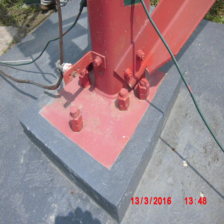

In [ ]:
item_tfms[0](Image.open(train_path / 'base_plate/CIMG4695.jpg'))

### Train and validation datasets

In [ ]:
train_dataset = TowerPartsDataset(
    train_path,
    item_tfms,
    label_to_int
)

valid_dataset = TowerPartsDataset(
    valid_path,
    item_tfms,
    label_to_int
)

In [ ]:
x, y = train_dataset[0]
x.shape, y

(torch.Size([3, 224, 224]), 0)

### Previewing transformed images

The warning occurs because the images has been normalized.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


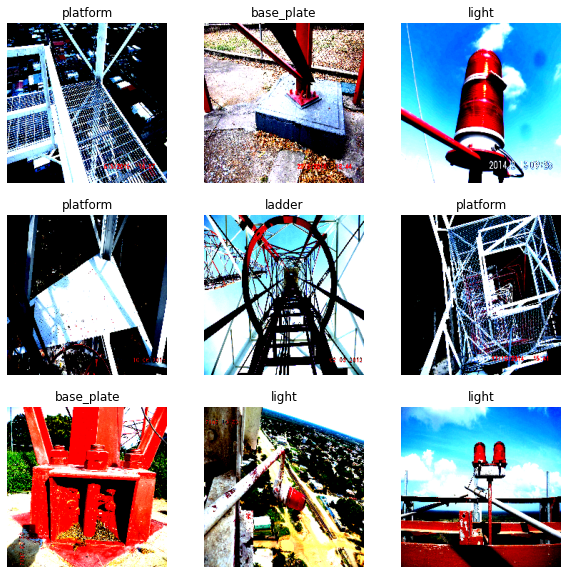

In [ ]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = int_to_label[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
    
plt.show()

## DataLoader

In [ ]:
batch_size = 64

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=batch_size
)

In [ ]:
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size*2
)

## Creating a PyTorch Model

When loading a model to fastai learner, it is customized by changing the last two children (the Head).   

What we are going to do here is to change only what is essential for our problem, that is, the final linear layer in order to have 8 features (the number of labels need to classify).  

For more detail on this I encourage you to take [Walk with fastai, the missing pieces for success](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html)

In [ ]:
from torchvision.models import resnet18, resnet34
model = resnet34(pretrained=True)

### Customizing the last linear layer

These are the two layers that are changed by fastai when creating the learner:

In [ ]:
model_child = list(model.children())
model_child[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

We can access the original final layer with `model.fc`

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

It has the 1,000 features resnet was trained for. We need to change it to the 8 features (labels, classes) of the problem we are dealing here:

In [ ]:
model.fc = nn.Linear(512, out_features=number_of_labels, bias=True)

In [ ]:
model.fc

Linear(in_features=512, out_features=8, bias=True)

### Gradual Unfreezing

One other thing fastai does is it freeze the backbone (Body) of the model. We can achieve that as follows:

In [ ]:
"""for layer in list(model.children())[:-1]:
    if hasattr(layer, "requires_grad_"):
        layer.requires_grad_(False)""";

::: {.callout-note}  
Zach used gradual unfreezing and `fit_one_cycle` in [Walk with fastai, the missing pieces for success](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html). Here I'm going to use `fine_tune` instead to compare with results in Part 1.
:::

## The Optimizer

Let's use the same optimizer as fastai's default: `AdamW`

In [ ]:
from torch.optim import AdamW
from functools import partial
from fastai.optimizer import OptimWrapper

In [ ]:
opt_func = partial(OptimWrapper, opt=AdamW)

## Bringing in fastai and Training!

In [ ]:
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy, error_rate
from fastai.learner import Learner
from fastai.callback.schedule import Learner # To get `fit_one_cycle`, `lr_find`, and more

from fastai.data.core import DataLoaders

In [ ]:
model.cuda();

In [ ]:
dls = DataLoaders(train_dataloader, valid_dataloader)

In [ ]:
learn = Learner(
    dls, 
    model, 
    opt_func=opt_func, 
    loss_func=CrossEntropyLossFlat(), 
    metrics=error_rate
)

CPU times: user 1h 46min 47s, sys: 12min 46s, total: 1h 59min 33s
Wall time: 22min 55s


SuggestedLRs(valley=5.248074739938602e-05)

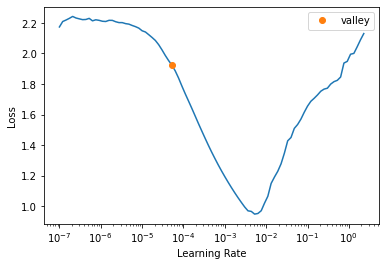

In [ ]:
%%time
learn.lr_find()

::: {.callout-note}  
In [Part 1](./Part_1__Tower_Parts_Classisfier_with_fastai.ipynb#fastai's-lr_find) it took 5 minutes for `lr_find()` to run, and the suggested lr was about 0.001. Now, with PyTorch's Dataloaders things got very different. Should keep digging in the causes.
:::

### Fine Tuning
> fine_tuning is geared towards transfer learning specifically. [“fine_tune” vs. “fit_one_cycle”](https://forums.fast.ai/t/fine-tune-vs-fit-one-cycle/66029/4)  

`fine_tune` does one epoch to train only the last layer (the linear layer we just modified). It means that the parameter of all the other layers are not changed, are "freezed". But after that epoch, all the model is "unfreezed" and trained. So the parameters of all its layers are updated or optmized.

In [ ]:
%%time
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.041510,1.549582,0.283333,02:02


epoch,train_loss,valid_loss,error_rate,time
0,0.095129,1.055718,0.208333,01:59
1,0.171666,2.795403,0.300000,02:02
2,0.146215,0.879028,0.166667,02:01


CPU times: user 35min 42s, sys: 4min 46s, total: 40min 29s
Wall time: 8min 7s


In [ ]:
learn.fit(2, lr=5.25e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.047634,0.423191,0.116667,02:00
1,0.033922,0.314130,0.100000,01:58


In [ ]:
from fastai.interpret import ClassificationInterpretation

try:
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(8,8))
except Exception as inst:
    print(inst)

'DataLoader' object has no attribute 'new'


In [ ]:
learn.save("exported_model_from_pytorch-fastai", with_opt=False)

Path('models/exported_model_from_pytorch-fastai.pth')

## Conclusions
- For some reason when starting with a PyTorch Dataloader `lr_find` takes more than 20 minutes to run. 4 times what it took in [Part 1](./Part_1__Tower_Parts_Classisfier_with_fastai.ipynb#fastai's-lr_find) where fastai's Dataloaders were used.
- It takes 2 minutes to train each epoch, which in [Part 1](Part_1__Tower_Parts_Classisfier_with_fastai.ipynb#Training) took less than a minute.
- The error rate wasn't that good after the 3 epochs of fine tuning. 16% vs 6% in [Part 1](Part_1__Tower_Parts_Classisfier_with_fastai.ipynb#Training). It took two more epochs with the learning rate suggested by `lr_find` to lower the error rate to 10%. Maybe the customized fastai head plays an important role here.
- fastai's `Dataloaders` created from PyTorch's `Dataloader` missed some attributed needed for fastai's `ClassificationInterpretation` to run.